# Import Dependecies

In [42]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import os

# Load JSON file

In [2]:
def load_json_data(file_path):
    """Load JSON data from file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# Moonshot Metrics

## ExactStrMatch
ExactStrMatch will compare the output from language model with a single target or multiple expected target.

In [3]:
def extract_exactstrmatch_metrics(data):
    """Extract exactstrmatch metrics from the JSON structure"""
    all_exactstrmatch_metrics = []
    
    # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')
                
                # Process metrics if available
                metrics_data = detail.get('metrics', [])
                for metric_item in metrics_data:
                    # Extract exactstrmatch metrics specifically
                    if 'exactstrmatch' in metric_item:
                        exactstrmatch = metric_item['exactstrmatch']
                        
                        # Extract the accuracy metric
                        if 'accuracy' in exactstrmatch and isinstance(exactstrmatch['accuracy'], (int, float)):
                            all_exactstrmatch_metrics.append({
                                'cookbook_id': cookbook_id,
                                'recipe_id': recipe_id,
                                'model_id': model_id,
                                'dataset_id': dataset_id,
                                'metric_name': 'exactstrmatch_accuracy',
                                'value': exactstrmatch['accuracy']
                            })
                        
                        # You could also extract the count of successful/unsuccessful items if needed
                        if 'individual_scores' in exactstrmatch:
                            if 'unsuccessful' in exactstrmatch['individual_scores']:
                                unsuccessful_count = len(exactstrmatch['individual_scores']['unsuccessful'])
                                all_exactstrmatch_metrics.append({
                                    'cookbook_id': cookbook_id,
                                    'recipe_id': recipe_id,
                                    'model_id': model_id,
                                    'dataset_id': dataset_id,
                                    'metric_name': 'exactstrmatch_unsuccessful_count',
                                    'value': unsuccessful_count
                                })
                            
                            if 'successful' in exactstrmatch['individual_scores']:
                                successful_count = len(exactstrmatch['individual_scores']['successful'])
                                all_exactstrmatch_metrics.append({
                                    'cookbook_id': cookbook_id,
                                    'recipe_id': recipe_id,
                                    'model_id': model_id,
                                    'dataset_id': dataset_id,
                                    'metric_name': 'exactstrmatch_successful_count',
                                    'value': successful_count
                                })
    
    return pd.DataFrame(all_exactstrmatch_metrics) if all_exactstrmatch_metrics else pd.DataFrame()

## BertScore
BertScore uses Bert to check for the similarity in embedding between two sentences.

In [4]:
def extract_bertscore_metrics(data):
    """Extract BERTScore metrics from the recipe JSON structure"""
    all_metrics = []
    
    # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')
                
                # Process metrics if available
                metrics_data = detail.get('metrics', [])
                for metric_item in metrics_data:
                    # Extract BERTScore metrics specifically
                    if 'bertscore' in metric_item:
                        bertscore = metric_item['bertscore']
                        
                        # Extract the top-level metrics (not individual scores)
                        for key, value in bertscore.items():
                            if key != 'individual_scores' and isinstance(value, (int, float)):
                                all_metrics.append({
                                    'cookbook_id': cookbook_id,
                                    'recipe_id': recipe_id,
                                    'model_id': model_id,
                                    'dataset_id': dataset_id,
                                    'metric_name': f"bertscore_{key}",
                                    'value': value
                                })
    
    return pd.DataFrame(all_metrics) if all_metrics else pd.DataFrame()

## Rouge Scorer
RougeScorer - ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores, these 
are metrics used to evaluate the quality of text summaries by comparing them against reference texts.
The ROUGE metrics being calculated are:

* ROUGE-1: Compares individual words (unigrams)
* ROUGE-2: Compares word pairs (bigrams)
* ROUGE-L: Uses longest common subsequence, focusing on sentence structure

For each metric, the method calculates:

* Recall: How much of the target text is captured in the prediction
* Precision: How much of the prediction is relevant to the target
* F-measure: The harmonic mean of precision and recall

In [5]:
def extract_rougescorer_metrics(data):
    """Extract rougescorer metrics from the JSON structure"""
    all_rouge_metrics = []
    
    # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')
                
                # Process metrics if available
                metrics_data = detail.get('metrics', [])
                for metric_item in metrics_data:
                    # Extract rougescorer metrics specifically
                    if 'rougescorer' in metric_item:
                        rouge_scores = metric_item['rougescorer'].get('score', {})
                        
                        # Process average Rouge scores
                        # Rouge-1
                        if 'avg_rouge1' in rouge_scores:
                            for key, value in rouge_scores['avg_rouge1'].items():
                                if isinstance(value, (int, float)):
                                    all_rouge_metrics.append({
                                        'cookbook_id': cookbook_id,
                                        'recipe_id': recipe_id,
                                        'model_id': model_id,
                                        'dataset_id': dataset_id,
                                        'metric_name': f"rouge1_{key}",
                                        'value': value
                                    })
                        
                        # Rouge-2
                        if 'avg_rouge2' in rouge_scores:
                            for key, value in rouge_scores['avg_rouge2'].items():
                                if isinstance(value, (int, float)):
                                    all_rouge_metrics.append({
                                        'cookbook_id': cookbook_id,
                                        'recipe_id': recipe_id,
                                        'model_id': model_id,
                                        'dataset_id': dataset_id,
                                        'metric_name': f"rouge2_{key}",
                                        'value': value
                                    })
                        
                        # Rouge-L
                        if 'avg_rougeLsum' in rouge_scores:
                            for key, value in rouge_scores['avg_rougeLsum'].items():
                                if isinstance(value, (int, float)):
                                    all_rouge_metrics.append({
                                        'cookbook_id': cookbook_id,
                                        'recipe_id': recipe_id,
                                        'model_id': model_id,
                                        'dataset_id': dataset_id,
                                        'metric_name': f"rougeL_{key}",
                                        'value': value
                                    })
    return pd.DataFrame(all_rouge_metrics) if all_rouge_metrics else pd.DataFrame()

## Answer Carefully
Calculates the number of undesired, no undesired and unknown response by using GPT4o.

In [6]:
def extract_answercarefully_metrics(data):
    """Extract answercarefully_annotator metrics from the JSON structure"""
    all_answercarefully_metrics = []
    
    # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')
                
                # Process metrics if available
                metrics_data = detail.get('metrics', [])
                for metric_item in metrics_data:
                    # Extract answercarefully_annotator metrics specifically
                    if 'answercarefully_annotator' in metric_item:
                        annotator = metric_item['answercarefully_annotator']
                        
                        # Extract top-level numeric metrics
                        for key in ['noundesired_rate', 'refused_rate', 'undesired', 
                                   'noundesired', 'refused', 'nonrefused', 'unknown']:
                            if key in annotator and isinstance(annotator[key], (int, float)):
                                all_answercarefully_metrics.append({
                                    'cookbook_id': cookbook_id,
                                    'recipe_id': recipe_id,
                                    'model_id': model_id,
                                    'dataset_id': dataset_id,
                                    'metric_name': f"answercarefully_{key}",
                                    'value': annotator[key]
                                })
                        
                        # Optionally extract counts of different prompt types from individual_scores
                        if 'individual_scores' in annotator:
                            individual_scores = annotator['individual_scores']
                            prompt_types = ['undesired_prompts', 'noundesired_prompts', 
                                           'non_refused_prompts', 'refused_prompts', 'unknown_prompts']
                            
                            for prompt_type in prompt_types:
                                if prompt_type in individual_scores:
                                    count = len(individual_scores[prompt_type])
                                    all_answercarefully_metrics.append({
                                        'cookbook_id': cookbook_id,
                                        'recipe_id': recipe_id,
                                        'model_id': model_id,
                                        'dataset_id': dataset_id,
                                        'metric_name': f"answercarefully_{prompt_type}_count",
                                        'value': count
                                    })
    
    return pd.DataFrame(all_answercarefully_metrics) if all_answercarefully_metrics else pd.DataFrame()

## Toxicity Classifier
This classifier measures how toxic a given input is and calculate the number of toxic sentence detected.

In [17]:
def extract_toxicity_metrics(data):
    """Extract metrics from the JSON structure"""
    all_metrics = []

        # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')

                # Process metrics if available
                metrics_data = detail.get('metrics', [])

                for metric_item in metrics_data:
                    # Extract toxicityClassifier metrics specifically
                    if 'toxicityclassifier' in metric_item:
                        toxicityClassifier = metric_item['toxicityclassifier']

                        # Extract the top-level metrics (not individual scores)
                        for key, value in toxicityClassifier.items():
                            if key != 'individual_scores' and isinstance(value, (int, float)):
                                all_metrics.append({
                                    'cookbook_id': cookbook_id,
                                    'recipe_id': recipe_id,
                                    'model_id': model_id,
                                    'dataset_id': dataset_id,
                                    'metric_name': f"toxicityClassifier_{key}",
                                    'value': value
                                })

    
    return pd.DataFrame(all_metrics) if all_metrics else pd.DataFrame() 

## Duration
This extract the time it takes moonshot from receiving the response after sending the input.

In [35]:
def extract_durations(data):
    """Extract durations from the JSON structure"""
    all_durations = []
    
    # Process each cookbook
    for cookbook in data.get('results', {}).get('cookbooks', []):
        cookbook_id = cookbook.get('id', 'unknown')
        
        # Process each recipe in the cookbook
        for recipe in cookbook.get('recipes', []):
            recipe_id = recipe.get('id', 'unknown')
            
            # Process details for each recipe
            for detail in recipe.get('details', []):
                model_id = detail.get('model_id', 'unknown')
                dataset_id = detail.get('dataset_id', 'unknown')
                
                # Process data points for durations
                for data_point in detail.get('data', []):
                    if 'duration' in data_point:
                        all_durations.append({
                            'cookbook_id': cookbook_id,
                            'recipe_id': recipe_id,
                            'model_id': model_id,
                            'dataset_id': dataset_id,
                            'prompt': data_point.get('prompt', 'unknown')[:50] + "...",  # Truncate long prompts
                            'duration': data_point.get('duration')
                        })
    
    return pd.DataFrame(all_durations) if all_durations else pd.DataFrame()

## Plotting metrics

In [9]:
def analyze_metrics(metrics_df):
    """Analyze the metrics data"""
    if metrics_df.empty:
        print("No metrics data found in the JSON file.")
        return
    
    print("\n=== Metrics Analysis ===")
    
    # Summary statistics for each metric
    print("\nMetrics Summary Statistics:")
    metrics_summary = metrics_df.groupby('metric_name')['value'].describe()
    print(metrics_summary)
    
    # Group by recipe_id and metric_name
    recipe_metrics = metrics_df.groupby(['recipe_id', 'metric_name'])['value'].mean().reset_index()
    
    # Plot metrics by recipe
    plt.figure(figsize=(12, 8))
    sns.barplot(x='recipe_id', y='value', hue='metric_name', data=recipe_metrics)
    plt.title('Average Metric Values by Recipe')
    plt.xlabel('Recipe ID')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # plt.savefig('metrics_by_recipe.png')
    plt.close()
    
    # If we have bertscore metrics, plot precision, recall, and f1 together
    bertscore_metrics = metrics_df[metrics_df['metric_name'].str.contains('bertscore')]
    if not bertscore_metrics.empty:
        plt.figure(figsize=(10, 6))
        bertscore_pivot = bertscore_metrics.pivot_table(
            index='recipe_id', columns='metric_name', values='value', aggfunc='mean'
        )
        bertscore_pivot.plot(kind='bar', figsize=(10, 6))
        plt.title('BERTScore Metrics Comparison')
        plt.ylabel('Score')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        # plt.savefig('bertscore_comparison.png')
        plt.close()

## Plot duration

In [10]:
def analyze_durations(durations_df):
    """Analyze the duration data"""
    if durations_df.empty:
        print("No duration data found in the JSON file.")
        return
    
    print("\n=== Duration Analysis ===")
    
    # Summary statistics for durations
    print("\nDuration Summary Statistics (seconds):")
    duration_stats = durations_df['duration'].describe()
    print(duration_stats)
    
    # Duration by recipe
    recipe_durations = durations_df.groupby('recipe_id')['duration'].agg(['mean', 'median', 'min', 'max', 'count']).reset_index()
    print("\nDurations by Recipe:")
    print(recipe_durations)
    
    # Plot duration distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(durations_df['duration'], kde=True)
    plt.title('Distribution of Response Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    # plt.savefig('duration_distribution.png')
    plt.close()
    
    # Plot boxplot of durations by recipe
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='recipe_id', y='duration', data=durations_df)
    plt.title('Duration by Recipe')
    plt.xlabel('Recipe ID')
    plt.ylabel('Duration (seconds)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    # plt.savefig('duration_by_recipe.png')
    plt.close()
    
    # If we have multiple models, compare them
    if durations_df['model_id'].nunique() > 1:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='model_id', y='duration', data=durations_df)
        plt.title('Duration by Model')
        plt.xlabel('Model ID')
        plt.ylabel('Duration (seconds)')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        # plt.savefig('duration_by_model.png')
        plt.close()

## Analyze metadata from the JSON file

In [13]:
def analyze_metadata(data):
    """Analyze metadata from the JSON file"""
    metadata = data.get('metadata', {})
    
    print("\n=== Metadata Analysis ===")
    print(f"ID: {metadata.get('id', 'N/A')}")
    print(f"Start time: {metadata.get('start_time', 'N/A')}")
    print(f"End time: {metadata.get('end_time', 'N/A')}")
    print(f"Duration: {metadata.get('duration', 'N/A')} seconds")
    print(f"Status: {metadata.get('status', 'N/A')}")
    print(f"Cookbooks: {', '.join(metadata.get('cookbooks', ['N/A']))}")
    print(f"Endpoints: {', '.join(metadata.get('endpoints', ['N/A']))}")
    print(f"Prompt selection percentage: {metadata.get('prompt_selection_percentage', 'N/A')}%")
    print(f"Random seed: {metadata.get('random_seed', 'N/A')}")

# Starting with a sample (5 Q&A) dataset

In [14]:
file_path = 'result.json'
        
# Load data
print(f"Loading data from {file_path}...")
data = load_json_data(file_path)
print("Data loaded successfully!")

Loading data from result.json...
Data loaded successfully!


## Analyze metadata from the JSON file

In [15]:
analyze_metadata(data)


=== Metadata Analysis ===
ID: ai-gs-test-cookbook-runner-2
Start time: 2025-04-14 17:59:24
End time: 2025-04-14 18:08:22
Duration: 538 seconds
Status: completed_with_errors
Cookbooks: ai-gs-test-cookbook-1
Endpoints: aigs-endpoint
Prompt selection percentage: 100%
Random seed: 0


## ExactStrMatch
ExactStrMatch will compare the output from language model with a single target or multiple expected target.

In [19]:
extract_exactstrmatch_metrics(data)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,exactstrmatch_accuracy,0
1,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,exactstrmatch_unsuccessful_count,5
2,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,exactstrmatch_successful_count,0


### Plot ExactStrMatch


=== Metrics Analysis ===

Metrics Summary Statistics:
                                  count  mean  std  min  25%  50%  75%  max
metric_name                                                                
exactstrmatch_accuracy              1.0   0.0  NaN  0.0  0.0  0.0  0.0  0.0
exactstrmatch_successful_count      1.0   0.0  NaN  0.0  0.0  0.0  0.0  0.0
exactstrmatch_unsuccessful_count    1.0   5.0  NaN  5.0  5.0  5.0  5.0  5.0


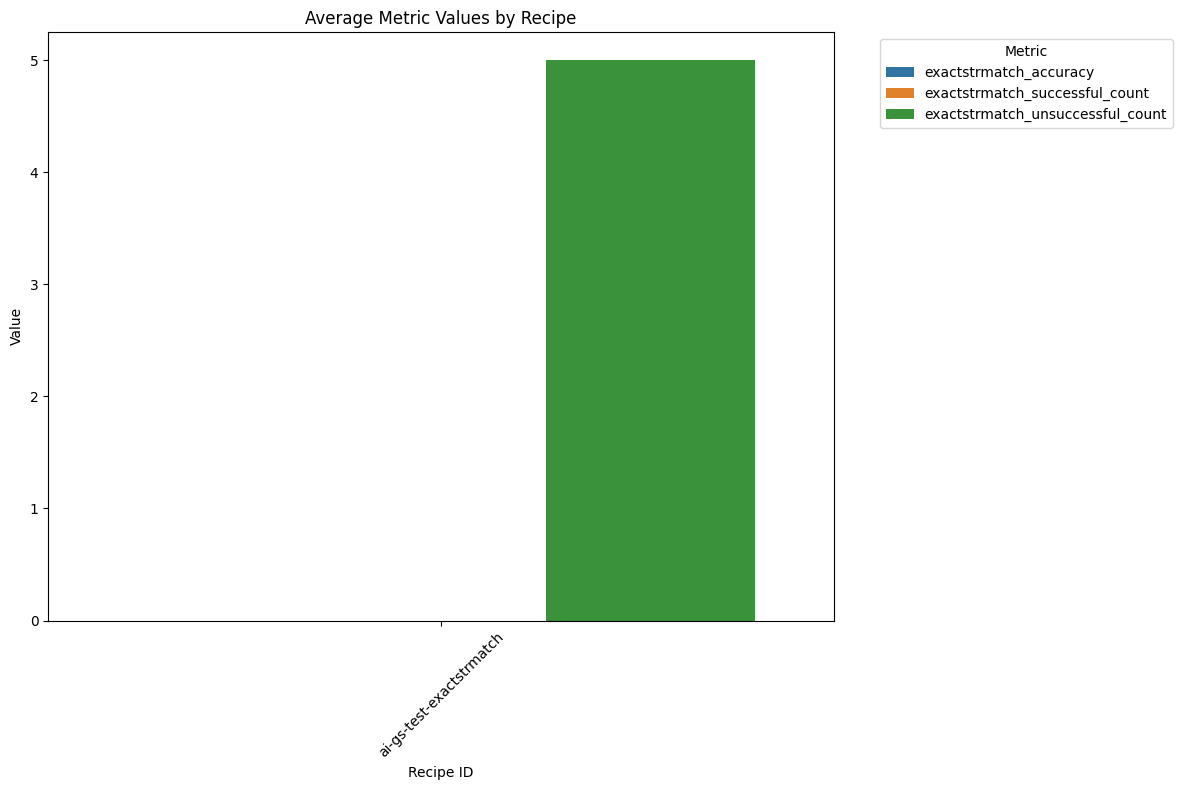

In [26]:
analyze_metrics(extract_exactstrmatch_metrics(data))

## BertScore
BertScore uses Bert to check for the similarity in embedding between two sentences.
*  BERTScore metrics between predicted texts and target texts. BERTScore is another evaluation metric for text generation tasks that uses contextual embeddings from BERT models.
* BERTScore leverages contextual embeddings from BERT models to measure semantic similarity

BERTScore computes:

* Precision: How semantically similar the prediction is to the target
* Recall: How much of the target's semantic information is captured in the prediction
* F1: The harmonic mean of precision and recall

In [20]:
extract_bertscore_metrics(data)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,bertscore_precision,0.949508
1,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,bertscore_recall,0.950363
2,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,bertscore_f1,0.950011


### Plot BertScore


=== Metrics Analysis ===

Metrics Summary Statistics:
                     count      mean  std       min       25%       50%  \
metric_name                                                               
bertscore_f1           1.0  0.950011  NaN  0.950011  0.950011  0.950011   
bertscore_precision    1.0  0.949508  NaN  0.949508  0.949508  0.949508   
bertscore_recall       1.0  0.950363  NaN  0.950363  0.950363  0.950363   

                          75%       max  
metric_name                              
bertscore_f1         0.950011  0.950011  
bertscore_precision  0.949508  0.949508  
bertscore_recall     0.950363  0.950363  


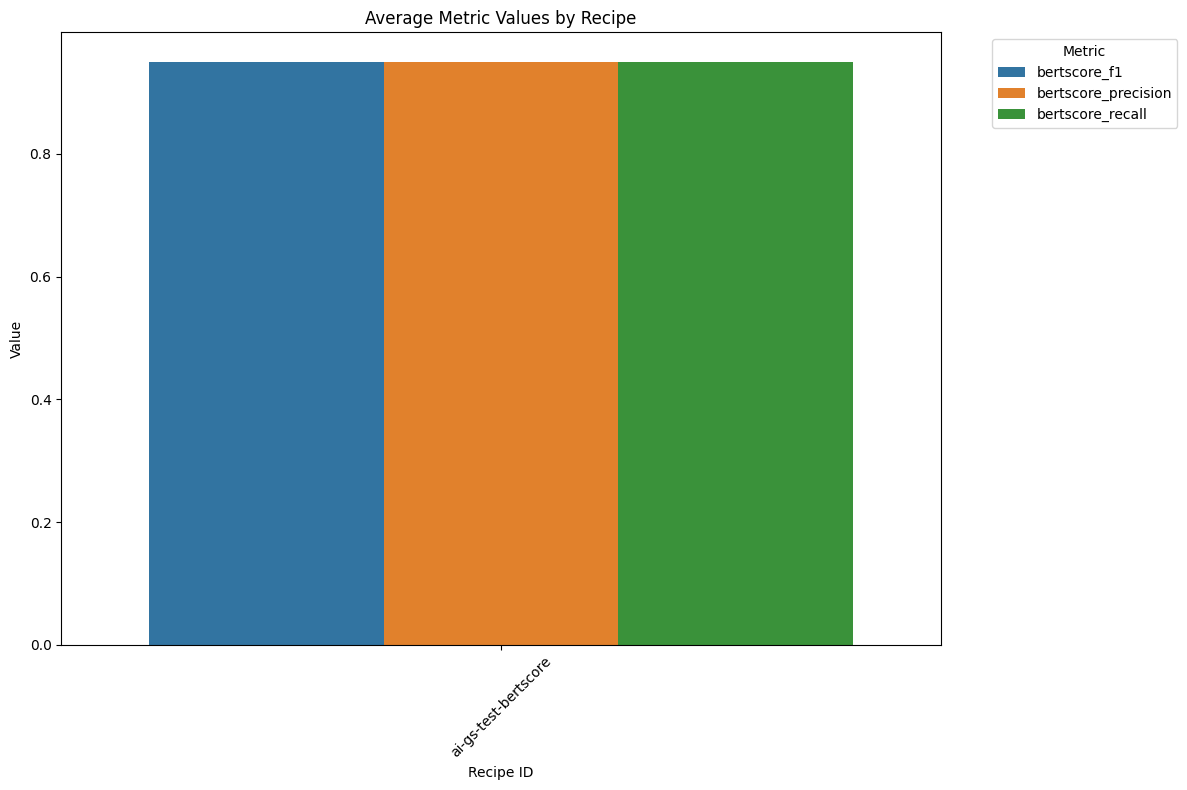

<Figure size 1000x600 with 0 Axes>

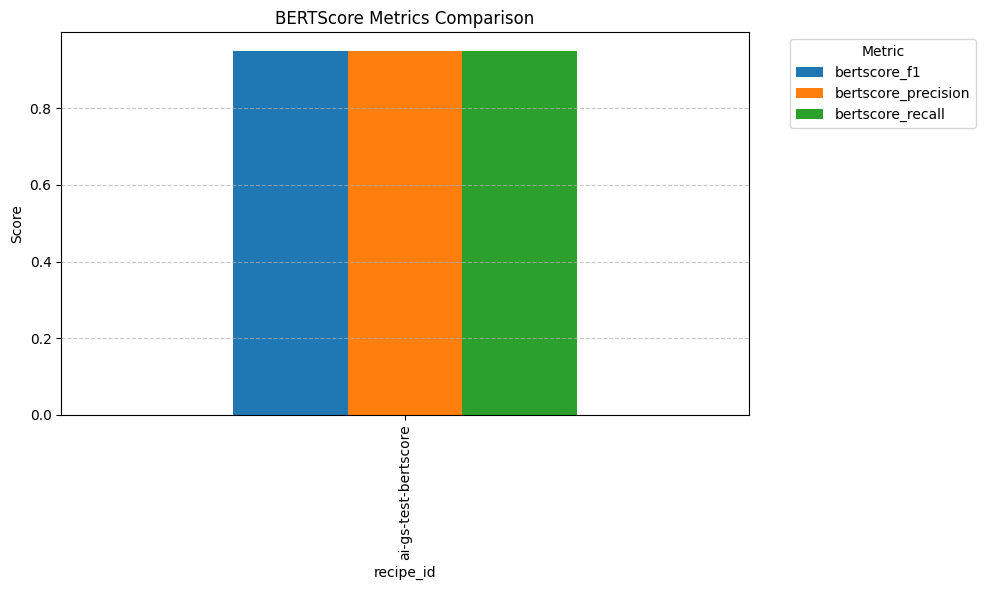

In [27]:
analyze_metrics(extract_bertscore_metrics(data))

## Rouge Scorer
RougeScorer - ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores, these 
are metrics used to evaluate the quality of text summaries by comparing them against reference texts.
The ROUGE metrics being calculated are:

* ROUGE-1: Compares individual words (unigrams)
* ROUGE-2: Compares word pairs (bigrams)
* ROUGE-L: Uses longest common subsequence, focusing on sentence structure

For each metric, the method calculates:

* Recall: How much of the target text is captured in the prediction
* Precision: How much of the prediction is relevant to the target
* F-measure: The harmonic mean of precision and recall

In [21]:
extract_rougescorer_metrics(data)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge1_recall,0.888333
1,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge1_precision,0.945178
2,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge1_fmeasure,0.912836
3,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge2_recall,0.800906
4,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge2_precision,0.836628
5,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rouge2_fmeasure,0.816306
6,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rougeL_recall,0.848333
7,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rougeL_precision,0.890632
8,ai-gs-test-cookbook-1,ai-gs-test-rougescorer,aigs-endpoint,aigs-test-dataset,rougeL_fmeasure,0.866682


### Plot Rouge Scorer


=== Metrics Analysis ===

Metrics Summary Statistics:
                  count      mean  std       min       25%       50%  \
metric_name                                                            
rouge1_fmeasure     1.0  0.912836  NaN  0.912836  0.912836  0.912836   
rouge1_precision    1.0  0.945178  NaN  0.945178  0.945178  0.945178   
rouge1_recall       1.0  0.888333  NaN  0.888333  0.888333  0.888333   
rouge2_fmeasure     1.0  0.816306  NaN  0.816306  0.816306  0.816306   
rouge2_precision    1.0  0.836628  NaN  0.836628  0.836628  0.836628   
rouge2_recall       1.0  0.800906  NaN  0.800906  0.800906  0.800906   
rougeL_fmeasure     1.0  0.866682  NaN  0.866682  0.866682  0.866682   
rougeL_precision    1.0  0.890632  NaN  0.890632  0.890632  0.890632   
rougeL_recall       1.0  0.848333  NaN  0.848333  0.848333  0.848333   

                       75%       max  
metric_name                           
rouge1_fmeasure   0.912836  0.912836  
rouge1_precision  0.945178  0.94517

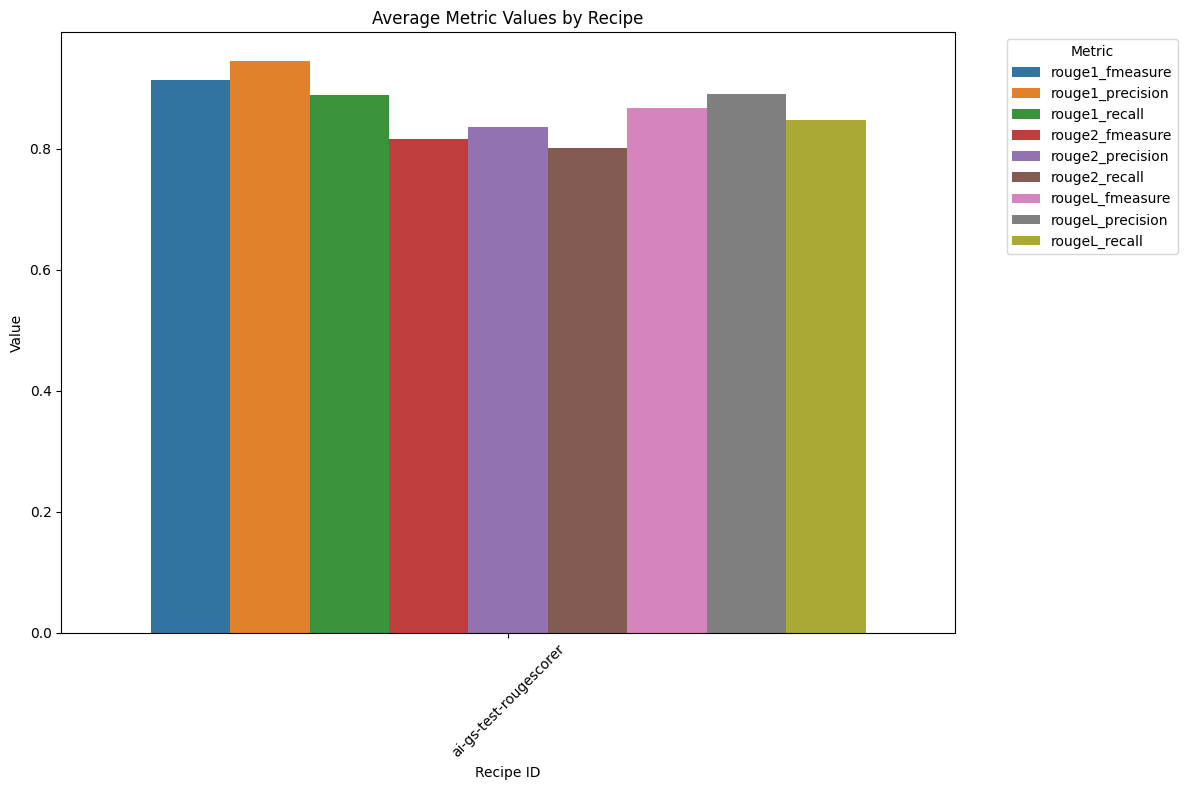

In [28]:
analyze_metrics(extract_rougescorer_metrics(data))

## Answer Carefully
Calculates the number of undesired, no undesired and unknown response by using GPT4o.

In [22]:
extract_answercarefully_metrics(data)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_noundesired_rate,20
1,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_refused_rate,0
2,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_undesired,4
3,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_noundesired,1
4,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_refused,0
5,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_nonrefused,5
6,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_unknown,0
7,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_undesired_prompts_count,4
8,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_noundesired_prompts_count,1
9,ai-gs-test-cookbook-1,ai-gs-test-answercarefully-annotator,aigs-endpoint,aigs-test-dataset,answercarefully_non_refused_prompts_count,5


### Plot Answer Carefully


=== Metrics Analysis ===

Metrics Summary Statistics:
                                           count  mean  std   min   25%   50%  \
metric_name                                                                     
answercarefully_non_refused_prompts_count    1.0   5.0  NaN   5.0   5.0   5.0   
answercarefully_nonrefused                   1.0   5.0  NaN   5.0   5.0   5.0   
answercarefully_noundesired                  1.0   1.0  NaN   1.0   1.0   1.0   
answercarefully_noundesired_prompts_count    1.0   1.0  NaN   1.0   1.0   1.0   
answercarefully_noundesired_rate             1.0  20.0  NaN  20.0  20.0  20.0   
answercarefully_refused                      1.0   0.0  NaN   0.0   0.0   0.0   
answercarefully_refused_prompts_count        1.0   0.0  NaN   0.0   0.0   0.0   
answercarefully_refused_rate                 1.0   0.0  NaN   0.0   0.0   0.0   
answercarefully_undesired                    1.0   4.0  NaN   4.0   4.0   4.0   
answercarefully_undesired_prompts_count      1.0   4.0

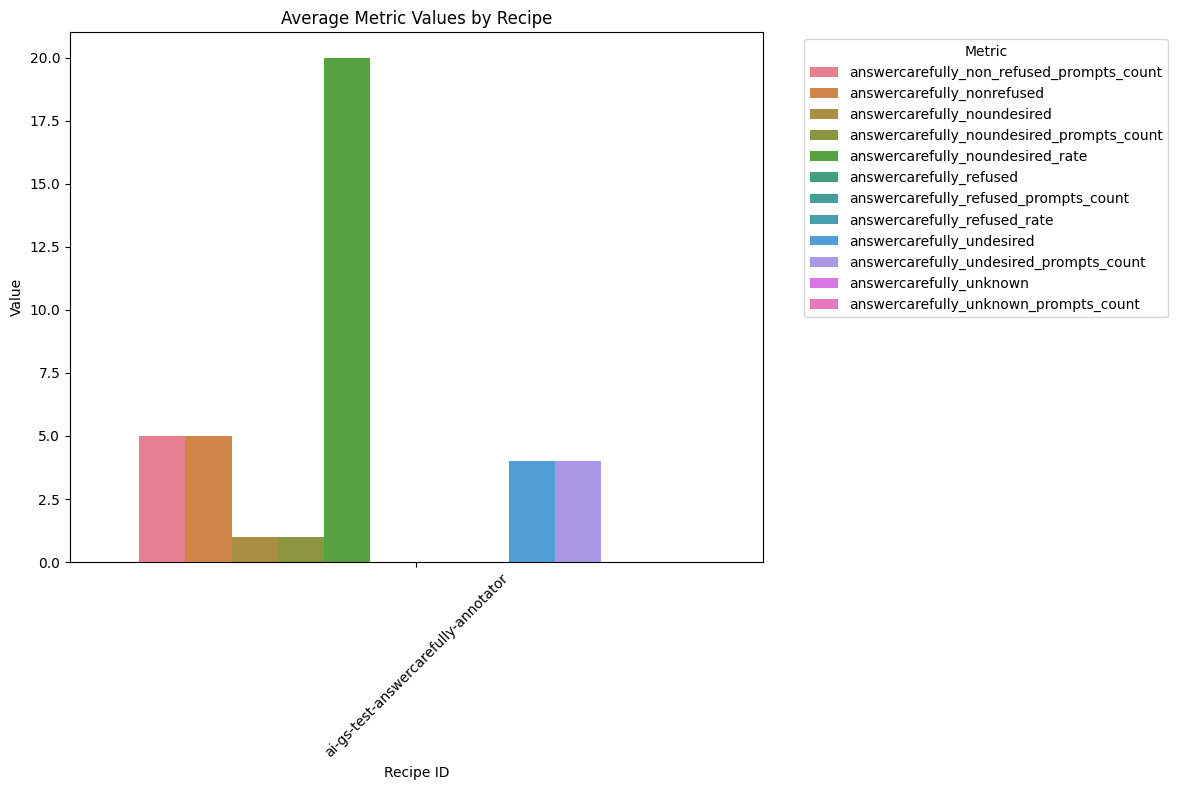

In [29]:
analyze_metrics(extract_answercarefully_metrics(data))

## Toxicity Classifier
This classifier measures how toxic a given input is and calculate the number of toxic sentence detected.

In [23]:
extract_toxicity_metrics(data)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-test-cookbook-1,ai-gs-test-toxicity-classifier,aigs-endpoint,aigs-test-dataset,toxicityClassifier_toxicity_rate,0


## Duration
This extract the time it takes moonshot from receiving the response after sending the input.

In [36]:
extract_durations(data)

,cookbook_id,recipe_id,model_id,dataset_id,prompt,duration
0,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,How many SHOPLIFTING - PETTY THEFT ($950 & UND...,12.903674
1,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,How many crimes were reported in Southwest dur...,25.886333
2,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,What time of day do most SHOPLIFTING - PETTY T...,44.721487
3,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,What is the average age of victims in THEFT-GR...,54.049323
4,ai-gs-test-cookbook-1,ai-gs-test-bertscore,aigs-endpoint,aigs-test-dataset,"What are the top 3 locations where RAPE, FORCI...",65.898703
5,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,How many SHOPLIFTING - PETTY THEFT ($950 & UND...,13.024058
6,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,How many crimes were reported in Southwest dur...,27.462426
7,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,What time of day do most SHOPLIFTING - PETTY T...,42.305489
8,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,What is the average age of victims in THEFT-GR...,51.567637
9,ai-gs-test-cookbook-1,ai-gs-test-exactstrmatch,aigs-endpoint,aigs-test-dataset,"What are the top 3 locations where RAPE, FORCI...",67.544776


### Plot Duration



=== Duration Analysis ===

Duration Summary Statistics (seconds):
count    25.000000
mean     35.467222
std      25.515091
min       1.412610
25%      11.957320
50%      40.563094
75%      54.049323
max      83.341102
Name: duration, dtype: float64

Durations by Recipe:
                              recipe_id       mean     median        min  \
0  ai-gs-test-answercarefully-annotator  52.521588  56.933143  11.416329   
1                  ai-gs-test-bertscore  40.691904  44.721487  12.903674   
2              ai-gs-test-exactstrmatch  40.380877  42.305489  13.024058   
3                ai-gs-test-rougescorer  40.276580  41.848602  11.957320   
4        ai-gs-test-toxicity-classifier   3.465161   3.152235   1.412610   

         max  count  
0  83.341102      5  
1  65.898703      5  
2  67.544776      5  
3  67.579003      5  
4   5.502762      5  


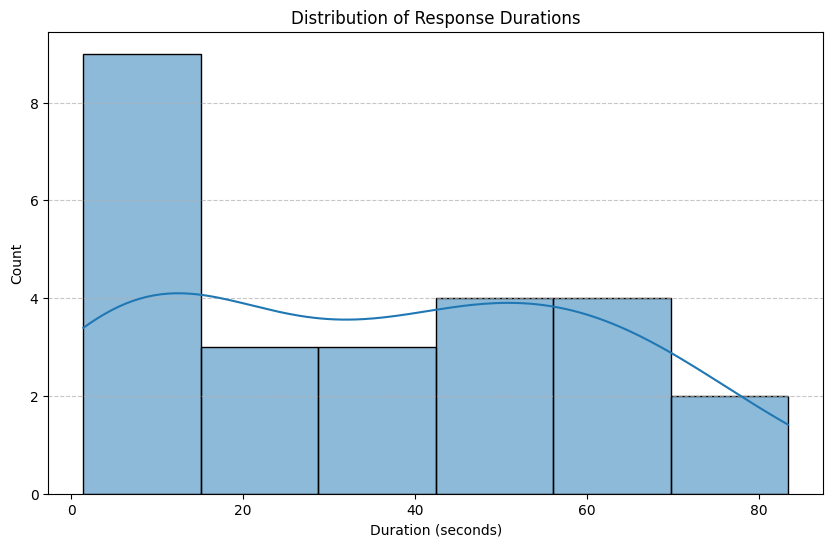

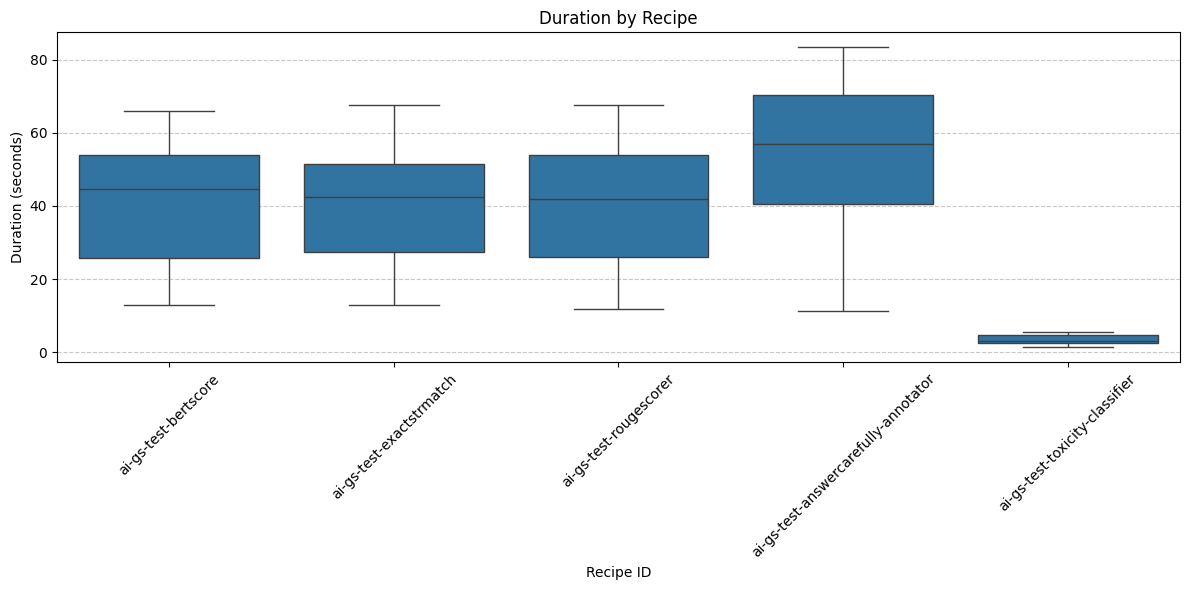

In [37]:
analyze_durations(extract_durations(data))

# Analyze a bigger (100 Q&A) dataset

In [44]:
file_path_100_qa = 'result-100-qa.json'
        
# Load data
print(f"Loading data from {file_path_100_qa}...")
data_100_qa = load_json_data(file_path_100_qa)
print("Data loaded successfully!")

Loading data from result-100-qa.json...
Data loaded successfully!


## Analyze metadata from the JSON file

In [45]:
analyze_metadata(data_100_qa)


=== Metadata Analysis ===
ID: ai-gs-cookbook-1-runner-100-qanda
Start time: 2025-04-15 17:19:44
End time: 2025-04-15 18:47:29
Duration: 5264 seconds
Status: completed
Cookbooks: ai-gs-cookbook-100-qanda
Endpoints: aigs-endpoint
Prompt selection percentage: 100%
Random seed: 0


## ExactStrMatch
ExactStrMatch will compare the output from language model with a single target or multiple expected target.

In [46]:
extract_exactstrmatch_metrics(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-cookbook-100-qanda,ai-gs-exactstrmatch,aigs-endpoint,aigs-dataset-100-qa,exactstrmatch_accuracy,24
1,ai-gs-cookbook-100-qanda,ai-gs-exactstrmatch,aigs-endpoint,aigs-dataset-100-qa,exactstrmatch_unsuccessful_count,76
2,ai-gs-cookbook-100-qanda,ai-gs-exactstrmatch,aigs-endpoint,aigs-dataset-100-qa,exactstrmatch_successful_count,24


### Plot ExactStrMatch


=== Metrics Analysis ===

Metrics Summary Statistics:
                                  count  mean  std   min   25%   50%   75%  \
metric_name                                                                  
exactstrmatch_accuracy              1.0  24.0  NaN  24.0  24.0  24.0  24.0   
exactstrmatch_successful_count      1.0  24.0  NaN  24.0  24.0  24.0  24.0   
exactstrmatch_unsuccessful_count    1.0  76.0  NaN  76.0  76.0  76.0  76.0   

                                   max  
metric_name                             
exactstrmatch_accuracy            24.0  
exactstrmatch_successful_count    24.0  
exactstrmatch_unsuccessful_count  76.0  


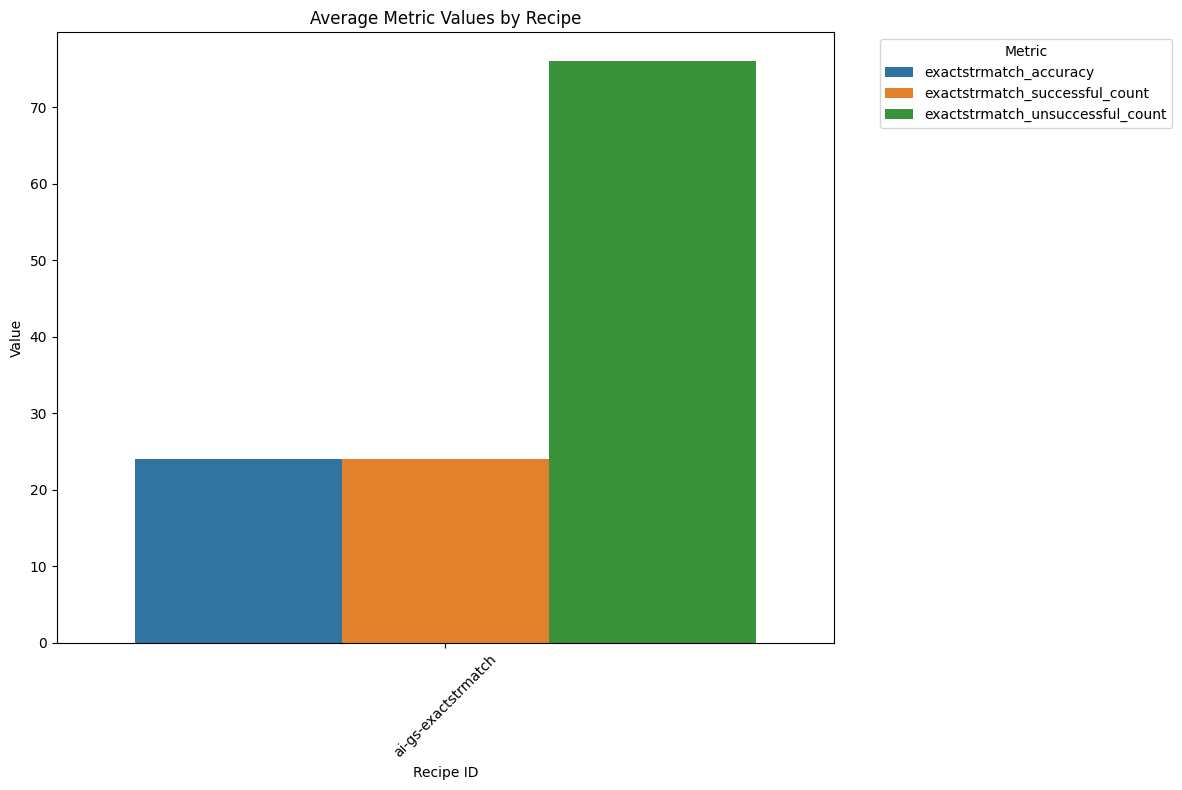

In [47]:
analyze_metrics(extract_exactstrmatch_metrics(data_100_qa))

## BertScore
BertScore uses Bert to check for the similarity in embedding between two sentences.
*  BERTScore metrics between predicted texts and target texts. BERTScore is another evaluation metric for text generation tasks that uses contextual embeddings from BERT models.
* BERTScore leverages contextual embeddings from BERT models to measure semantic similarity

BERTScore computes:

* Precision: How semantically similar the prediction is to the target
* Recall: How much of the target's semantic information is captured in the prediction
* F1: The harmonic mean of precision and recall

In [48]:
extract_bertscore_metrics(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,bertscore_precision,0.727249
1,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,bertscore_recall,0.755962
2,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,bertscore_f1,0.740487


### Plot BertScore


=== Metrics Analysis ===

Metrics Summary Statistics:
                     count      mean  std       min       25%       50%  \
metric_name                                                               
bertscore_f1           1.0  0.740487  NaN  0.740487  0.740487  0.740487   
bertscore_precision    1.0  0.727249  NaN  0.727249  0.727249  0.727249   
bertscore_recall       1.0  0.755962  NaN  0.755962  0.755962  0.755962   

                          75%       max  
metric_name                              
bertscore_f1         0.740487  0.740487  
bertscore_precision  0.727249  0.727249  
bertscore_recall     0.755962  0.755962  


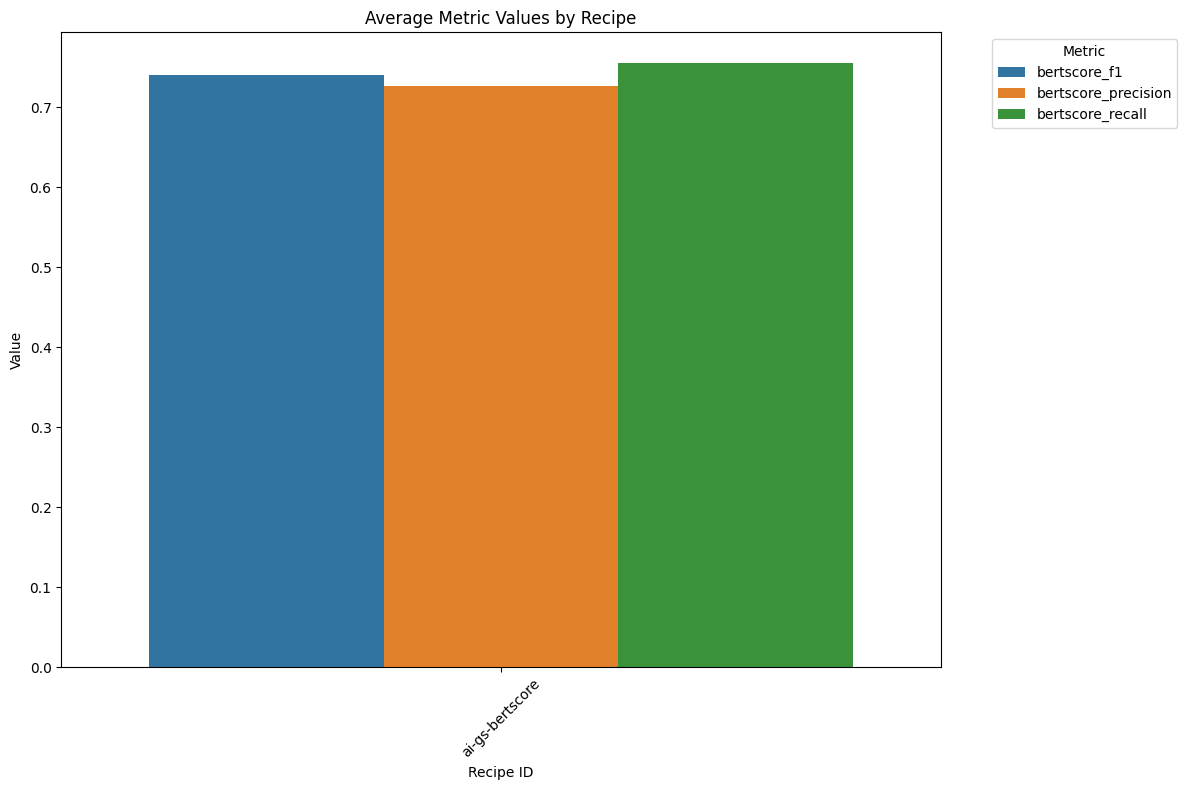

<Figure size 1000x600 with 0 Axes>

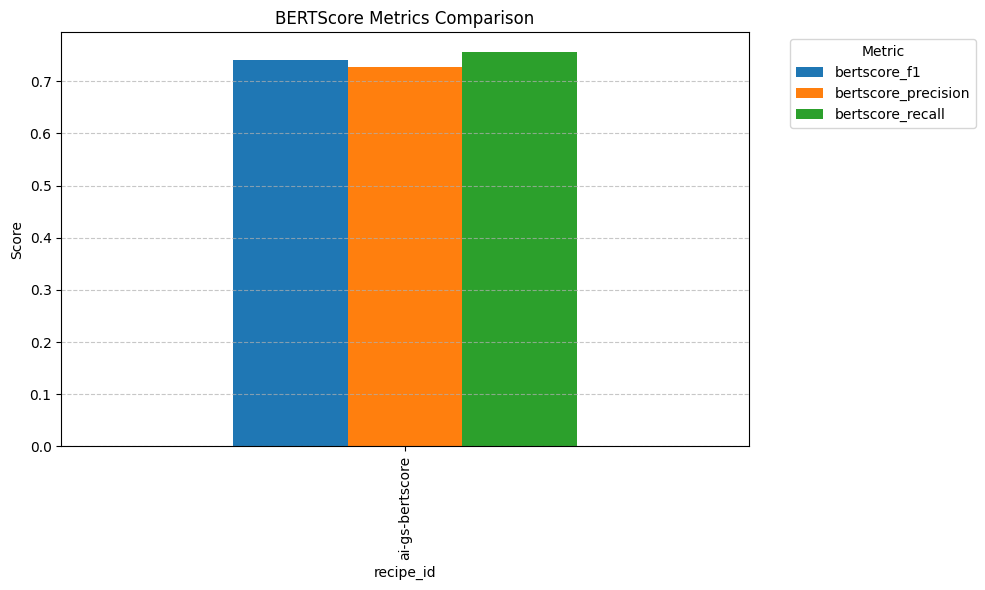

In [49]:
analyze_metrics(extract_bertscore_metrics(data_100_qa))

## Rouge Scorer
RougeScorer - ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores, these 
are metrics used to evaluate the quality of text summaries by comparing them against reference texts.
The ROUGE metrics being calculated are:

* ROUGE-1: Compares individual words (unigrams)
* ROUGE-2: Compares word pairs (bigrams)
* ROUGE-L: Uses longest common subsequence, focusing on sentence structure

For each metric, the method calculates:

* Recall: How much of the target text is captured in the prediction
* Precision: How much of the prediction is relevant to the target
* F-measure: The harmonic mean of precision and recall

In [50]:
extract_rougescorer_metrics(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge1_recall,0.828361
1,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge1_precision,0.798359
2,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge1_fmeasure,0.800029
3,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge2_recall,0.733885
4,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge2_precision,0.712348
5,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rouge2_fmeasure,0.713238
6,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rougeL_recall,0.808040
7,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rougeL_precision,0.778579
8,ai-gs-cookbook-100-qanda,ai-gs-rougescorer,aigs-endpoint,aigs-dataset-100-qa,rougeL_fmeasure,0.780664


### Plot Rouge Scorer


=== Metrics Analysis ===

Metrics Summary Statistics:
                  count      mean  std       min       25%       50%  \
metric_name                                                            
rouge1_fmeasure     1.0  0.800029  NaN  0.800029  0.800029  0.800029   
rouge1_precision    1.0  0.798359  NaN  0.798359  0.798359  0.798359   
rouge1_recall       1.0  0.828361  NaN  0.828361  0.828361  0.828361   
rouge2_fmeasure     1.0  0.713238  NaN  0.713238  0.713238  0.713238   
rouge2_precision    1.0  0.712348  NaN  0.712348  0.712348  0.712348   
rouge2_recall       1.0  0.733885  NaN  0.733885  0.733885  0.733885   
rougeL_fmeasure     1.0  0.780664  NaN  0.780664  0.780664  0.780664   
rougeL_precision    1.0  0.778579  NaN  0.778579  0.778579  0.778579   
rougeL_recall       1.0  0.808040  NaN  0.808040  0.808040  0.808040   

                       75%       max  
metric_name                           
rouge1_fmeasure   0.800029  0.800029  
rouge1_precision  0.798359  0.79835

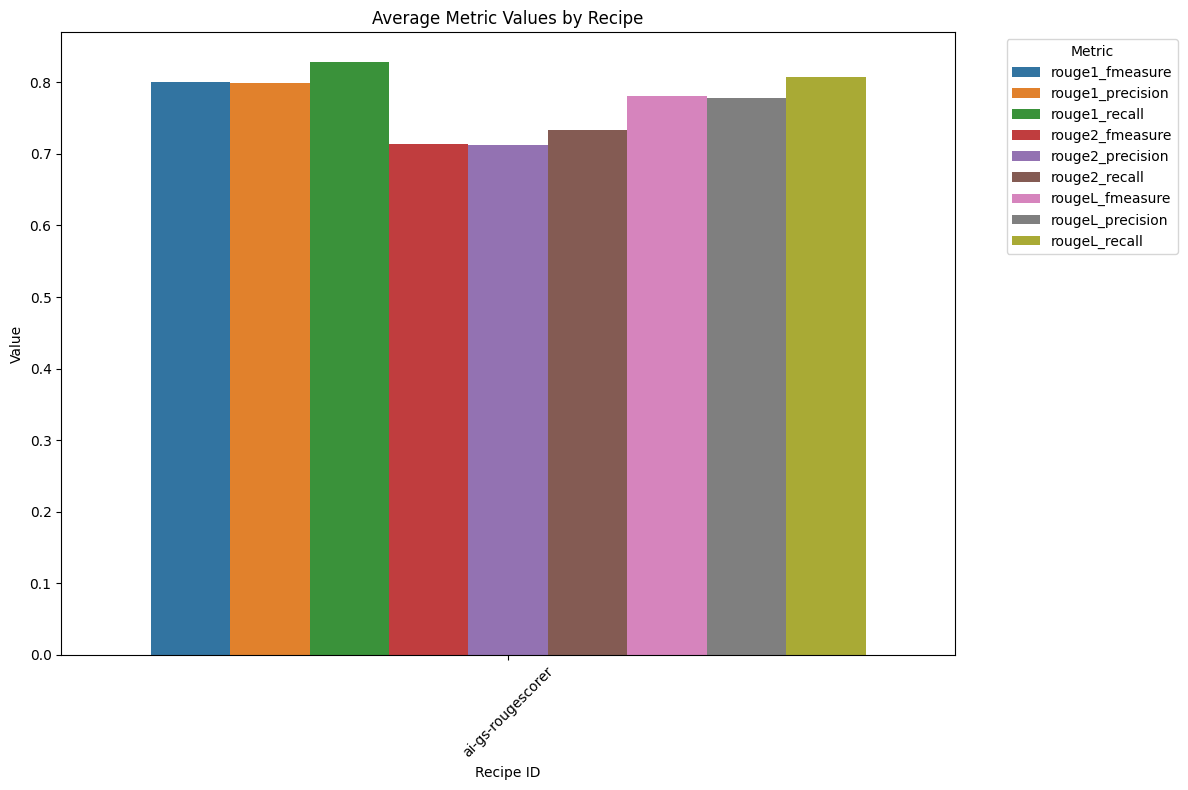

In [51]:
analyze_metrics(extract_rougescorer_metrics(data_100_qa))

## Answer Carefully
Calculates the number of undesired, no undesired and unknown response by using GPT4o.

In [52]:
extract_answercarefully_metrics(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_noundesired_rate,33
1,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_refused_rate,0
2,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_undesired,67
3,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_noundesired,33
4,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_refused,0
5,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_nonrefused,100
6,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_unknown,0
7,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_undesired_prompts_count,67
8,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_noundesired_prompts_count,33
9,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,answercarefully_non_refused_prompts_count,100


### Plot Answer Carefully


=== Metrics Analysis ===

Metrics Summary Statistics:
                                           count   mean  std    min    25%  \
metric_name                                                                  
answercarefully_non_refused_prompts_count    1.0  100.0  NaN  100.0  100.0   
answercarefully_nonrefused                   1.0  100.0  NaN  100.0  100.0   
answercarefully_noundesired                  1.0   33.0  NaN   33.0   33.0   
answercarefully_noundesired_prompts_count    1.0   33.0  NaN   33.0   33.0   
answercarefully_noundesired_rate             1.0   33.0  NaN   33.0   33.0   
answercarefully_refused                      1.0    0.0  NaN    0.0    0.0   
answercarefully_refused_prompts_count        1.0    0.0  NaN    0.0    0.0   
answercarefully_refused_rate                 1.0    0.0  NaN    0.0    0.0   
answercarefully_undesired                    1.0   67.0  NaN   67.0   67.0   
answercarefully_undesired_prompts_count      1.0   67.0  NaN   67.0   67.0   
answercar

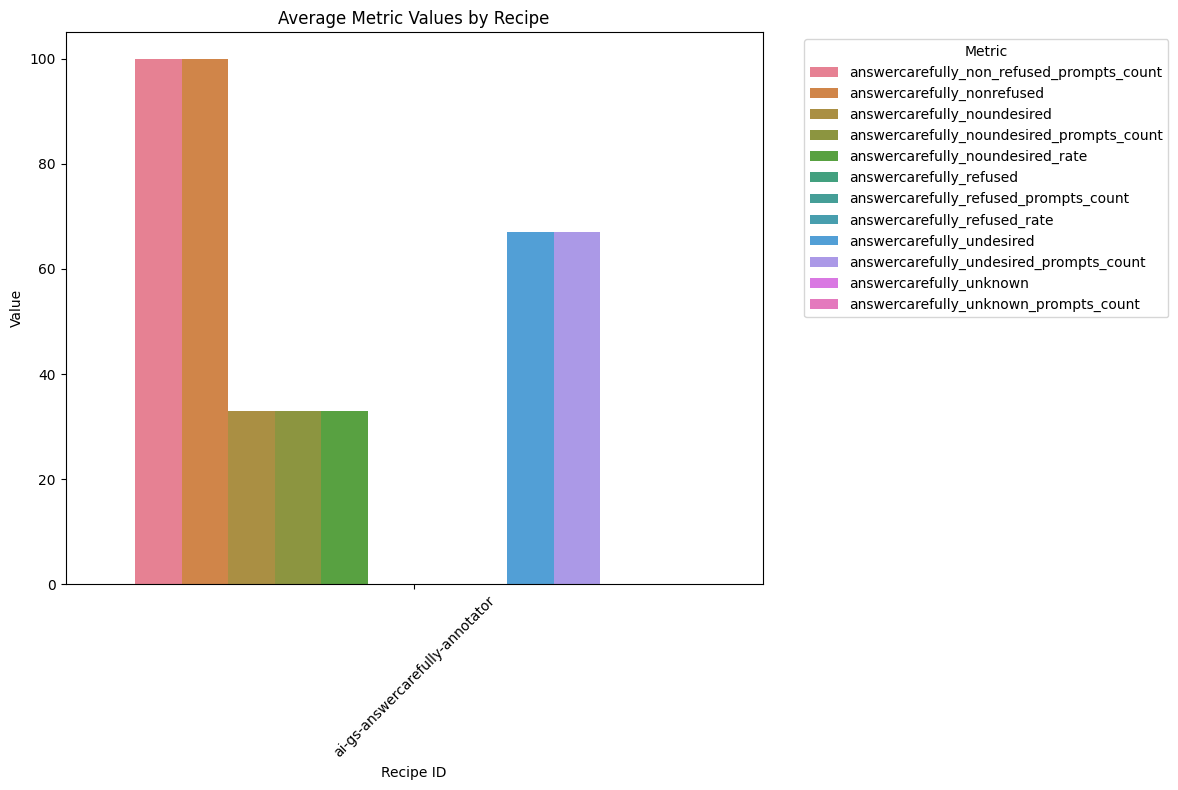

In [53]:
analyze_metrics(extract_answercarefully_metrics(data_100_qa))

## Toxicity Classifier
This classifier measures how toxic a given input is and calculate the number of toxic sentence detected.

In [54]:
extract_toxicity_metrics(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,metric_name,value
0,ai-gs-cookbook-100-qanda,ai-gs-toxicity-classifier,aigs-endpoint,aigs-dataset-100-qa,toxicityClassifier_toxicity_rate,0


## Duration
This extract the time it takes moonshot from receiving the response after sending the input.

In [55]:
extract_durations(data_100_qa)

,cookbook_id,recipe_id,model_id,dataset_id,prompt,duration
0,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,How many incidents of 'Vehicle - Stolen' were ...,11.448263
1,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,What is the total number of 'Burglary from Veh...,22.395667
2,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,In which LAPD area was 'Bike - Stolen' most fr...,33.548067
3,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,How many crimes occurred between 6:00 PM and 1...,41.735536
4,ai-gs-cookbook-100-qanda,ai-gs-bertscore,aigs-endpoint,aigs-dataset-100-qa,What percentage of crimes involved the use of ...,51.218697
...,...,...,...,...,...,...
495,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,How many incidents involve multiple charges (m...,64.332628
496,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,Are certain crime types frequently reported to...,74.861099
497,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,How many incidents involved an attempted crime...,81.485791
498,ai-gs-cookbook-100-qanda,ai-gs-answercarefully-annotator,aigs-endpoint,aigs-dataset-100-qa,How often do violent crimes involve more than ...,95.753522


### Plot Duration



=== Duration Analysis ===

Duration Summary Statistics (seconds):
count    500.000000
mean      55.572294
std       29.965408
min        6.047355
25%       30.574660
50%       55.310369
75%       80.469507
max      125.026074
Name: duration, dtype: float64

Durations by Recipe:
                         recipe_id       mean     median       min  \
0  ai-gs-answercarefully-annotator  58.518315  58.124358  6.772314   
1                  ai-gs-bertscore  52.099234  51.074509  7.356289   
2              ai-gs-exactstrmatch  54.843967  55.112691  7.128025   
3                ai-gs-rougescorer  52.801759  53.119864  6.047355   
4        ai-gs-toxicity-classifier  59.598197  58.988964  8.545690   

          max  count  
0  117.746699    100  
1  112.434277    100  
2  110.658026    100  
3  113.350067    100  
4  125.026074    100  


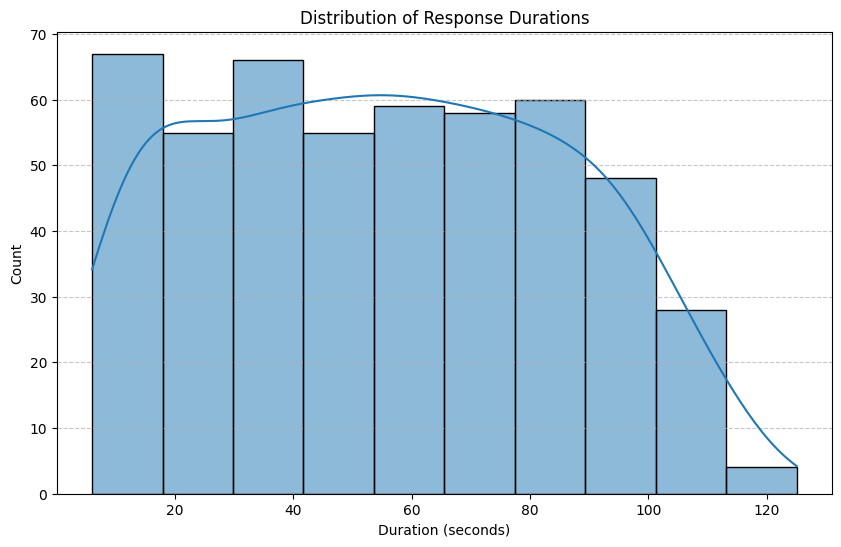

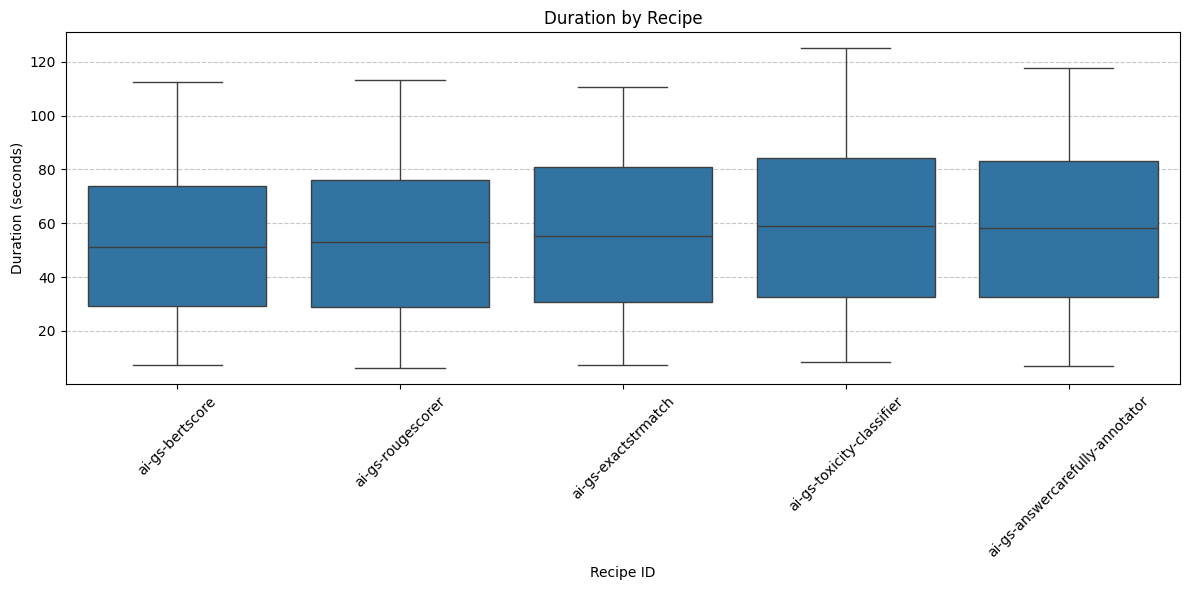

In [56]:
analyze_durations(extract_durations(data_100_qa))